In [1]:
import numpy as np
import bisect
import matplotlib.pyplot as plt
from RSCpp import RheoConfig as rconf
from RSCpp import FTrheo as ft

from IPython.display import display, Math

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.WARNING)
logging.info('Study of the impact of noise on phase reconstruction')

C:\Users\steaime\miniconda3\envs\DSH\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")
INFO:root:Study of the impact of noise on phase reconstruction


# Fourier analysis of oscillatory rheology: viscoelastic moduli

This notebook illustrates how to analyze oscillatory rheology data to extract linear and nonlinear viscoelastic moduli

### 1: load and plot data

See the general data analysis tutorial to learn how to open and handle raw data from experiments

In [2]:
froot = r'D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\03_Long'
rheo_protocol = rconf.RheoProtocol(froot)
rheo_explog = rheo_protocol.LoadExpLog()
rheo_explog

INFO:root:691 rows read from expLog file D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\03_Long\expLog.txt
INFO:root:expLog file updated with 2151 output file paths


,ID,Time,Type,Name,Force,Displacement,Speed,Period,Offset,RelOffset,...,StartPos,EndPos,StartForce,EndForce,Trigger,Active,Axis,StrainControlled,FilePath,FilePath_exists
0,1,40.5961,0,05_StrainSweep_0.1Hz_OSR0_0.01_000,<err>,0.01,0.00628319,10,0,1,...,15,15,0.0100024,0.15109,0,1,0,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True
1,2,81.2252,0,05_StrainSweep_0.1Hz_OSR0_0.01_001,<err>,0.0125893,0.00791006,10,0,1,...,15,15,0.234794,0.0673849,0,1,0,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True
2,3,121.766,0,05_StrainSweep_0.1Hz_OSR0_0.01_002,<err>,0.0158489,0.00995818,10,0,1,...,15,15,0.124241,0.136876,0,1,0,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True
3,4,162.281,0,05_StrainSweep_0.1Hz_OSR0_0.01_003,<err>,0.0199526,0.0125366,10,0,1,...,15,15,0.184782,0.100024,0,1,0,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True
4,5,202.838,0,05_StrainSweep_0.1Hz_OSR0_0.01_004,<err>,0.0251189,0.0157826,10,0,1,...,15,15,0.121082,0.0705435,0,1,0,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,17,2570.47,0,119_Relax_016,<err>,0.0251189,0.157826,1,0,1,...,12.0008,12.0008,-0.00186316,-0.00164495,0,1,1,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,False
686,18,2573.67,0,119_Relax_017,<err>,0.0199526,0.125366,1,0,1,...,12.0008,12.0008,-0.000570696,-0.000218207,0,1,1,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,False
687,19,2576.9,0,119_Relax_018,<err>,0.0158489,0.0995818,1,0,1,...,12.0008,12.0008,-0.000637837,0.00196387,0,1,1,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,False
688,20,2580.12,0,119_Relax_019,<err>,0.0125893,0.0791006,1,0,1,...,12.0008,12.0008,0.00129246,0.00115818,0,1,1,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,False


In [3]:
def plot_interval(int_idx, usecols=(1, 5, 6)):
    int_time, int_pos, int_force = rheo_protocol.ReadRheoData(int_idx, usecols=usecols)
    int_time_s = 1e-3*(int_time-int_time[0])
    int_displ = int_pos-int_pos[0]
    if int_pos is not None:
        fig, ax = plt.subplots(figsize=(12,8), nrows=2)
        ax[0].plot(int_time_s, -int_force, 'r-', label='force')
        ax[0].set_xlabel('time [s]')
        ax[0].set_ylabel('force')
        ax2 = ax[0].twinx()
        ax2.plot(int_time_s, int_displ, 'k-', label='position')
        ax2.set_ylabel('position')
        ax[1].plot(int_displ[100:], -int_force[100:], 'b-', label='Lissajous')
        ax[1].set_xlabel('position')
        ax[1].set_ylabel('force')

One example in the linear regime:

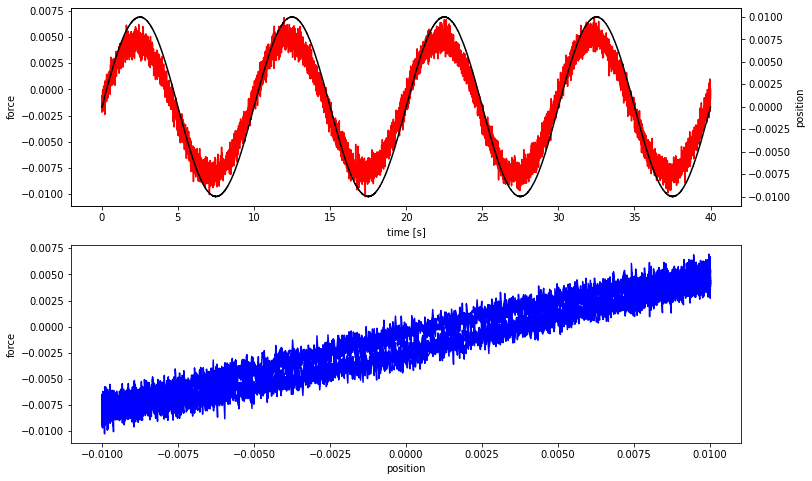

In [4]:
plot_interval(42)

Another in the nonlinear regime:

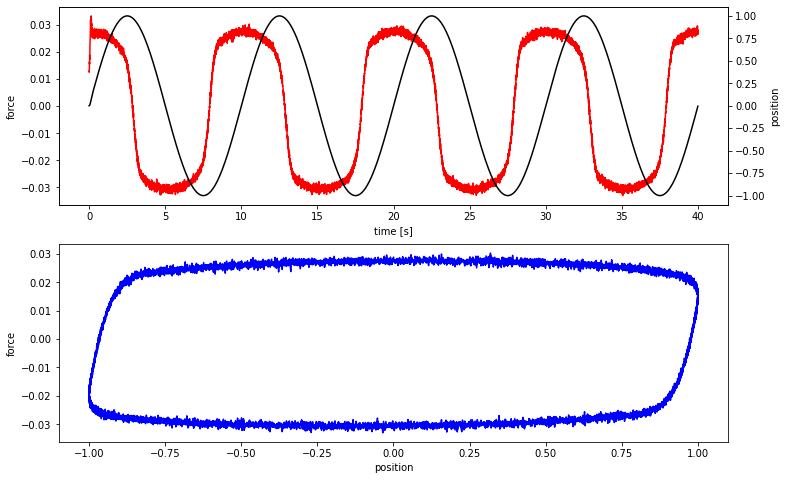

In [5]:
plot_interval(62)

### 2: Fourier analysis

Fourier analysis can be done using the function:

```python
FTrheo.FTrheo(t_list, x_list, f_list, Period=1.0, StartTime=1.0, AnalyzePeriods=1, HigherHarmonics=6, t_scale=1.0)
```

where:

- ```t_list``` are time datapoints. They can be in arbitrary units, ```t_scale``` is the parameter setting the conversion to time in seconds. **NOTE**: time points need to be equally spaced
- ```x_list, f_list``` are position and force data. Their units determine the units of the output moduli: if positions are in mm and forces in N, the output will be elastic constants in units of N/mm. If strain and stresses are given, output will be moduli in Pa.
- ```Period``` is the oscillatory period, in seconds
- ```StartTime``` sets the starting point of the analysis window relative to the first time point, in units of the oscillation period
- ```AnalyzePeriods``` is the number of periods to be analyzed. It must be an integer number
- ```HigherHarmonics``` is the number of higher-order harmonics to extract

The function returns:

- ```G*```, the complex, first-harmonic modulus
- ```opt```, a dictionnary with optional output parameters, including:
  - ```'F'```: the first harmonic of the force spectrum
  - ```'x'```: the first harmonic of the position spectrum
  - ```'F0'```: the DC component of the force
  - ```'Fn'```: a list of the first ```n``` harmonics of the force signal, up to ```HigherHarmonics```, normalized by the first harmonic
  - ```'F_fft', 'x_fft'```: the full Fourier spectrum of force and position, respectively
  - ```'fft_dw'```: the frequency step of the full spectrum

In [6]:
def ft_interval(int_idx, usecols=(1, 5, 6), Period=1, AnalyzePeriods=1, HigherHarmonics=6, verbose=0):
    int_time, int_pos, int_force = rheo_protocol.ReadRheoData(int_idx, usecols=usecols)
    if int_pos is not None:
        G, opt = ft.FTrheo(int_time, int_pos, -2*int_force, Period=Period, StartTime=0.5, AnalyzePeriods=AnalyzePeriods, 
                           HigherHarmonics=HigherHarmonics, verbose=verbose, t_scale=1000)
        wlist = np.arange(len(opt['x_fft']))*opt['fft_dw']
        fig, ax = plt.subplots(figsize=(12,8), nrows=2)
        ax[0].plot(wlist, np.abs(opt['F_fft']), 'k.-')
        for i in range(HigherHarmonics):
            ax[0].axvline(x=2*np.pi*i/Period, ls='--')
        ax2 = ax[0].twinx()
        ax2.plot(wlist, np.abs(opt['x_fft']), 'r.-')
        ax[0].set_xlabel('$\omega$ [rad/s]')
        ax[0].set_ylabel('$|\hat{F}|$')
        ax2.set_ylabel('$|\hat{x}|$')
        ax[0].set_xscale('log')
        ax[0].set_yscale('log')
        ax2.set_yscale('log')
        ax[1].bar(np.arange(HigherHarmonics), np.abs(opt['Fn'])*np.abs(G), color='g', label='$|G_n^*|$')
        ax[1].plot(wlist/(2*np.pi/Period), np.abs(opt['F_fft']/opt['F_fft'][AnalyzePeriods])*np.abs(G), 'b.-', label='$|\hat{F}_n/\hat{F}_1|$')
        ax[1].set_xlabel('$\omega/\omega_0$')
        ax[1].set_ylabel('$|G^*|$')
        ax[1].set_xlim([0, HigherHarmonics-1])
        ax[1].legend()
        
        display(Math('$G^*={0:.3f}~[N/mm]$'.format(np.abs(G))))
        display(Math('$G^\prime={0:.3f}~[N/mm]$'.format(np.real(G))))
        display(Math('$G"={0:.3f}~[N/mm]$'.format(np.imag(G))))
        display(Math('$\delta/\pi={0:.2f}$'.format(np.angle(G)/np.pi)))
        display(Math('$tan(\delta)={0:.3f}$'.format(np.tan(np.angle(G)))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

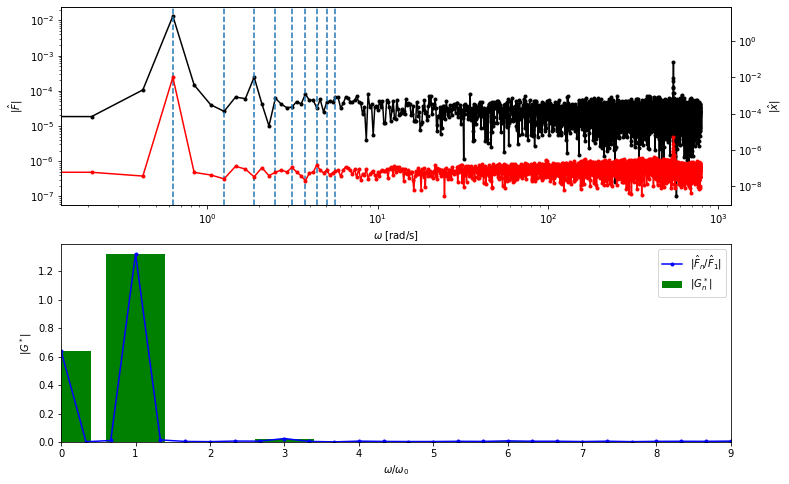

In [7]:
ft_interval(42, Period=10, AnalyzePeriods=3, HigherHarmonics=10)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

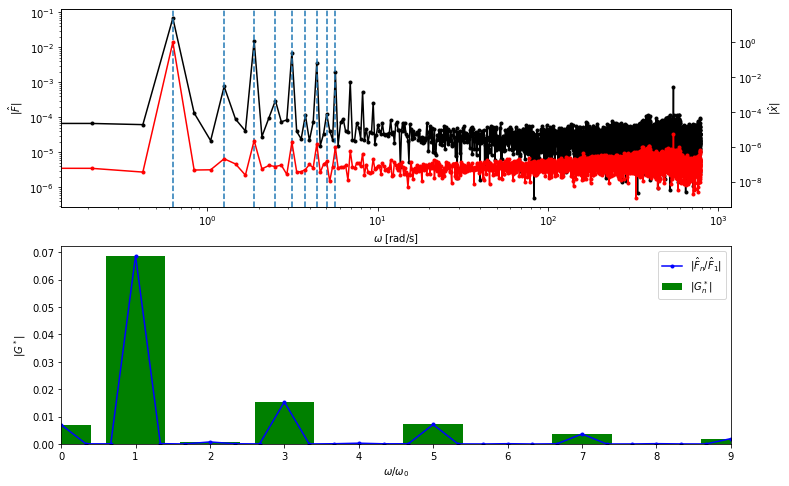

In [8]:
ft_interval(62, Period=10, AnalyzePeriods=3, HigherHarmonics=10)

### 3: estimating uncertainties

To estimate the uncertainties on viscoelastic moduli arising from noise on force data, we generate synthetic datasets with uncorrelated, Gaussian noise, and we analyze them using the same routines. We focus on uncertainty on $\delta$:

0.1403966927573141

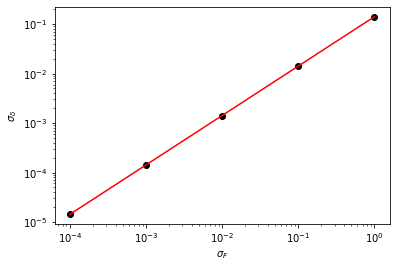

In [10]:
def model_delta_err(delta_true, N_times=100, N_rep=1000, noise_list=None, plot=False):
    t = np.linspace(0,1,N_times+1)
    strain = np.cos(2*np.pi*t)
    if noise_list is None:
        noise_list = np.geomspace(1e-4, 1, 5)
    noise_avgN = 1000
    delta_true = 0
    delta_err = np.empty((len(noise_list), noise_avgN), dtype=float)
    for i in range(len(noise_list)):
        for j in range(noise_avgN):
            cur_stress = np.cos(2*np.pi*t+delta_true)+np.random.normal(0,noise_list[i],len(t))
            cur_G, _ = ft.FTrheo(t, strain, cur_stress, Period=1, StartTime=0)
            delta_err[i,j] = np.angle(cur_G) - delta_true
    delta_std = np.std(delta_err, axis=1)
    fitp = np.polyfit(np.log(noise_list), np.log(delta_std), 1)

    if plot:
        fig, ax = plt.subplots()
        ax.plot(noise_list, delta_std, 'ko')
        ax.plot(noise_list, np.exp(fitp[0]*np.log(noise_list) + fitp[1]), 'r-')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('$\sigma_F$')
        ax.set_ylabel('$\sigma_\delta$')

    return np.exp(fitp[1])

model_delta_err(0, plot=True)

We find that the relationship is linear, and we describe it with just one parameter. We study it as a function of the ground truth for the phase:

Text(0, 0.5, '$\\sigma_\\delta/\\sigma_F$')

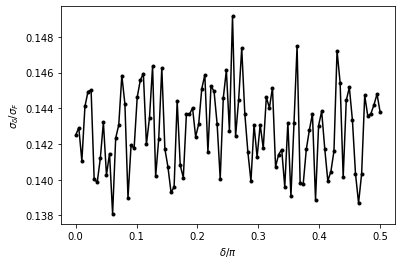

In [12]:
delta_list = np.linspace(0, np.pi/2, 100)
delta_std = [model_delta_err(d) for d in delta_list]

fig, ax = plt.subplots()
ax.plot(delta_list/np.pi, delta_std, 'k.-')
ax.set_xlabel('$\delta/\pi$')
ax.set_ylabel('$\sigma_\delta/\sigma_F$')